In [137]:
import seaborn as sns
import pandas as pd
import re
import matplotlib as mpl
from matplotlib import rc
import missingno as msno
import warnings
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
warnings.filterwarnings('ignore')

# matplotlib 한글 사용을 위한 코드
rc('font', family='AppleGothic')

In [138]:
X_train = pd.read_csv('X_train_09.csv').drop(columns='Unnamed: 0')
y_train = pd.read_csv('y_train_09.csv').drop(columns='Unnamed: 0')
X_test = pd.read_csv('X_test_09.csv').drop(columns='Unnamed: 0')
y_test = pd.read_csv('y_test_09.csv').drop(columns='Unnamed: 0')

In [139]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              740 non-null    object 
 1   director           740 non-null    object 
 2   distributor        740 non-null    object 
 3   distributor_group  740 non-null    object 
 4   release_date       740 non-null    object 
 5   release_season     740 non-null    object 
 6   nation             740 non-null    object 
 7   screen             740 non-null    int64  
 8   genre              740 non-null    object 
 9   rate               740 non-null    object 
 10  expert_rating      740 non-null    float64
 11  starring_actors    740 non-null    object 
 12  running_times      740 non-null    int64  
 13  audience_rating    740 non-null    float64
 14  rating_audiences   740 non-null    int64  
 15  director_power     740 non-null    float64
 16  sequel             740 non

In [140]:
df = pd.concat([X_train, y_train], axis=1)

In [141]:
group_a = ['씨제이이앤엠(주)', '메가박스중앙(주)플러스엠', 'CGV아트하우스', '롯데쇼핑㈜롯데엔터테인먼트',
           'CGV아트하우스,(주)대명문화공장', '롯데쇼핑㈜롯데엔터테인먼트,(주)마인스 엔터테인먼트',
           'CGV아트하우스,(주)리틀빅픽쳐스', 'CGV아트하우스,영화사 풀', '메가박스중앙(주)플러스엠,(주)키위미디어그룹',
           '롯데쇼핑㈜롯데엔터테인먼트,(주)리틀빅픽쳐스', '메가박스중앙(주)플러스엠,주식회사 키위컴퍼니',
           '씨제이 씨지브이(CJ CGV)(주)', '롯데컬처웍스(주)롯데엔터테인먼트',
           '롯데컬처웍스(주)롯데엔터테인먼트,씨네그루(주)키다리이엔티', '메가박스중앙(주)플러스엠,(주)콘텐츠 난다긴다',
           '씨제이이앤엠(주),(주)덱스터스튜디오', '(주)쇼박스', '(주)넥스트엔터테인먼트월드(NEW)', '(주)쇼박스,(주)와우픽쳐스',
           '(주)넥스트엔터테인먼트월드(NEW),(주)팬엔터테인먼트']
group_b = ['월트디즈니컴퍼니코리아(주)', '이십세기폭스코리아(주)', '유니버설픽쳐스인터내셔널 코리아(유)',
           '워너브러더스 코리아(주)', '씨네그루(주)다우기술', '(주)이수C&E', '(주)티캐스트',
           '씨네그루(주)키다리이엔티', '월트디즈니컴퍼니코리아 유한책임회사', '소니픽쳐스엔터테인먼트코리아주식회사극장배급지점',
           '(주)이수C&E,(주)스톰픽쳐스코리아', '씨네그루(주)키다리이엔티,주식회사 키위컴퍼니',
           '(주)이수C&E,(주)에이원엔터테인먼트', '씨네그루(주)키다리이엔티,(주)삼백상회',
           '(주)이수C&E,(주)시너지미디어', '(주)셀트리온엔터테인먼트', '케이티하이텔(주)']

In [142]:
df['dist_cat'] = df['distributor']

for a in group_a:
    df['dist_cat'] = df['dist_cat'].replace(a, 'A')

for b in group_b:
    df['dist_cat'] = df['dist_cat'].replace(b, 'B')

df['dist_cat'] = df['dist_cat'].apply(
    lambda data: "C" if data != 'A' and data != 'B' else data)

In [143]:
X_test['dist_cat'] = X_test['distributor']

for a in group_a:
    X_test['dist_cat'] = X_test['dist_cat'].replace(a, 'A')

for b in group_b:
    X_test['dist_cat'] = X_test['dist_cat'].replace(b, 'B')

X_test['dist_cat'] = X_test['dist_cat'].apply(
    lambda data: "C" if data != 'A' and data != 'B' else data)

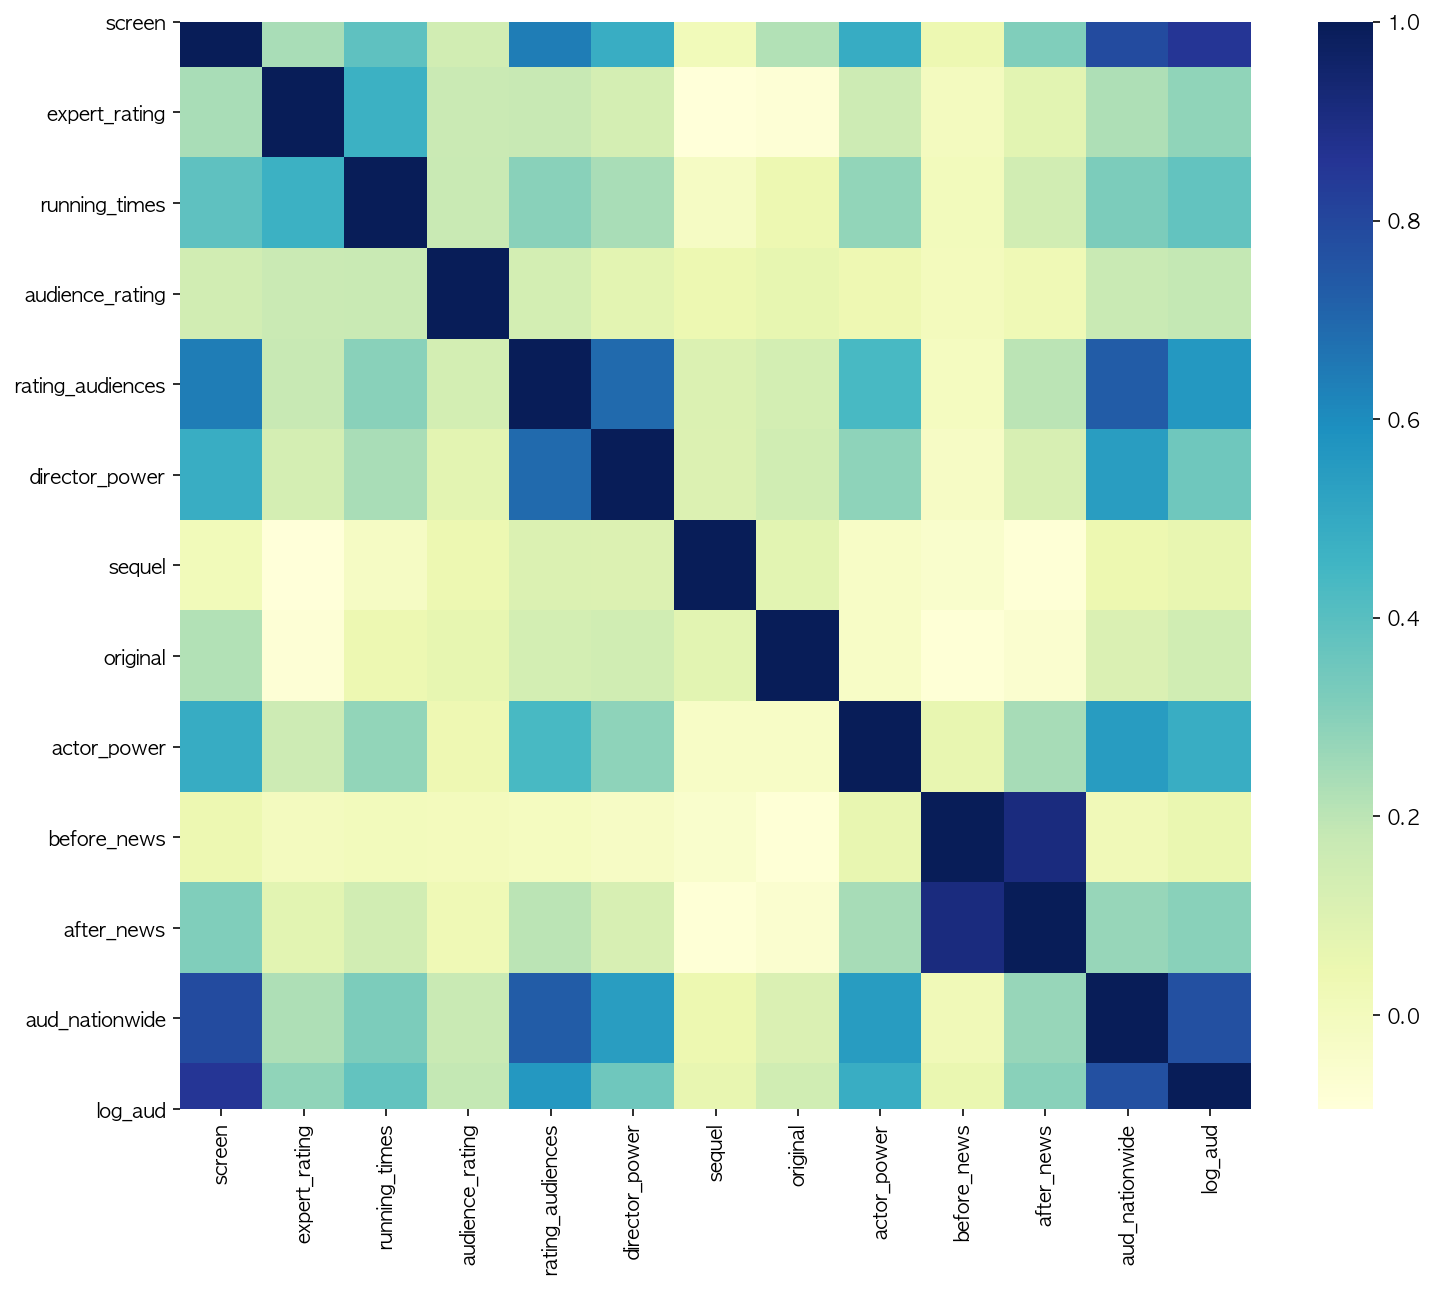

In [144]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap="YlGnBu")
plt.show()

In [145]:
kfold_dict = {}
kfold_dict_avr = []
kfold_df = pd.DataFrame()

# model0
- 아무 처리 안한 원본

In [146]:
df.columns

Index(['title', 'director', 'distributor', 'distributor_group', 'release_date',
       'release_season', 'nation', 'screen', 'genre', 'rate', 'expert_rating',
       'starring_actors', 'running_times', 'audience_rating',
       'rating_audiences', 'director_power', 'sequel', 'original',
       'actor_power', 'before_news', 'after_news', 'aud_nationwide', 'log_aud',
       'dist_cat'],
      dtype='object')

In [147]:
df0 = df.copy()

In [148]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'rating_audiences', 'director_power', 'actor_power', 'before_news', 'after_news']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'release_season', 'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model0 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df0)
result0 = model0.fit()
print(result0.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     58.62
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          5.47e-188
Time:                        12:44:51   Log-Likelihood:                -11275.
No. Observations:                 740   AIC:                         2.263e+04
Df Residuals:                     702   BIC:                         2.280e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [149]:
# kfold 0

from sklearn.model_selection import KFold

kfold_dict['0'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df0)):
    df_train = df0.iloc[idx_train]
    df_test = df0.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                                   'actor_power', 'before_news', 'after_news', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict['0'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['0'])/10)

학습 R2 = 0.78390876, 검증 R2 = 0.78528260
학습 R2 = 0.78648920, 검증 R2 = 0.75103586
학습 R2 = 0.78673211, 검증 R2 = 0.66727676
학습 R2 = 0.78837056, 검증 R2 = 0.74479025
학습 R2 = 0.78611346, 검증 R2 = 0.76045370
학습 R2 = 0.78815483, 검증 R2 = 0.73940537
학습 R2 = 0.78989304, 검증 R2 = 0.70998676
학습 R2 = 0.78783934, 검증 R2 = 0.74646547
학습 R2 = 0.78425455, 검증 R2 = 0.77823270
학습 R2 = 0.78765667, 검증 R2 = 0.74294697


In [150]:
# model0의 테스트 R

pred = result0.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                               'actor_power', 'before_news', 'after_news', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['aud_nationwide'] - pred) ** 2).sum()
tss = ((y_test['aud_nationwide'] - y_test['aud_nationwide'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7005251184088559

# model1
- 종속변수에 log 

In [151]:
df1 = df0.copy()

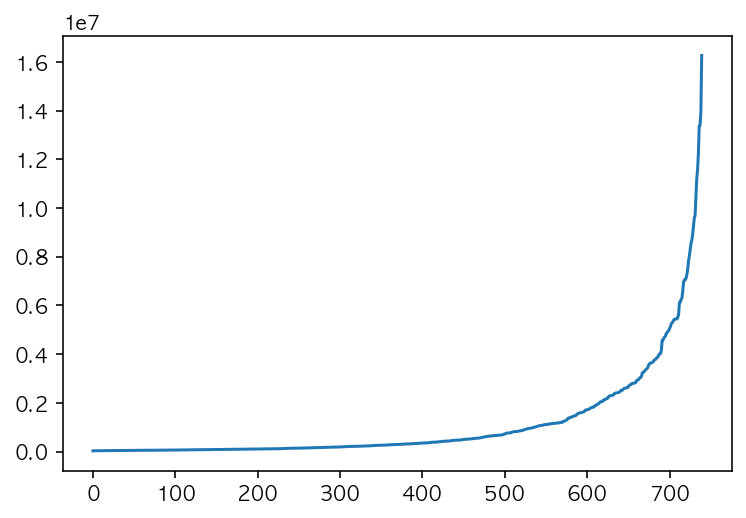

In [152]:
plt.plot(df1['aud_nationwide'].sort_values().reset_index(drop=True))

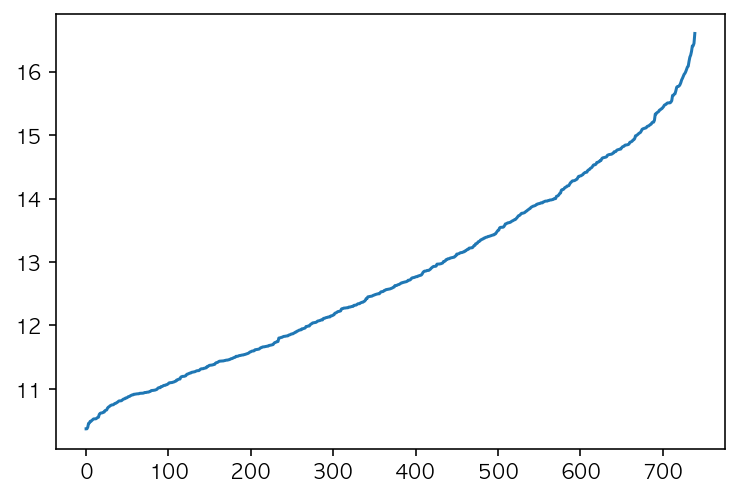

In [153]:
plt.plot(np.log(df1['aud_nationwide'].sort_values().reset_index(drop=True)))

In [154]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'rating_audiences', 'director_power', 'actor_power', 'before_news', 'after_news']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'release_season', 'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model1 = sm.OLS.from_formula("log_aud ~" + "+".join(feature_names), data=df1)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     69.36
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          1.86e-207
Time:                        12:45:03   Log-Likelihood:                -778.47
No. Observations:                 740   AIC:                             1633.
Df Residuals:                     702   BIC:                             1808.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [155]:
# kfold 1

from sklearn.model_selection import KFold

kfold_dict['1'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df1)):
    df_train = df1.iloc[idx_train]
    df_test = df1.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                                   'actor_power', 'before_news', 'after_news', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict['1'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
    
kfold_dict_avr.append(sum(kfold_dict['1'])/10)


학습 R2 = 0.78390876, 검증 R2 = 0.78528260
학습 R2 = 0.78648920, 검증 R2 = 0.75103586
학습 R2 = 0.78673211, 검증 R2 = 0.66727676
학습 R2 = 0.78837056, 검증 R2 = 0.74479025
학습 R2 = 0.78611346, 검증 R2 = 0.76045370
학습 R2 = 0.78815483, 검증 R2 = 0.73940537
학습 R2 = 0.78989304, 검증 R2 = 0.70998676
학습 R2 = 0.78783934, 검증 R2 = 0.74646547
학습 R2 = 0.78425455, 검증 R2 = 0.77823270
학습 R2 = 0.78765667, 검증 R2 = 0.74294697


In [156]:
# model1의 테스트 R

pred = result1.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                               'actor_power', 'before_news', 'after_news', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.75232013370038

# model2
- 뉴스기사 컬럼에 대한 처리

In [157]:
df2 = df1.copy()

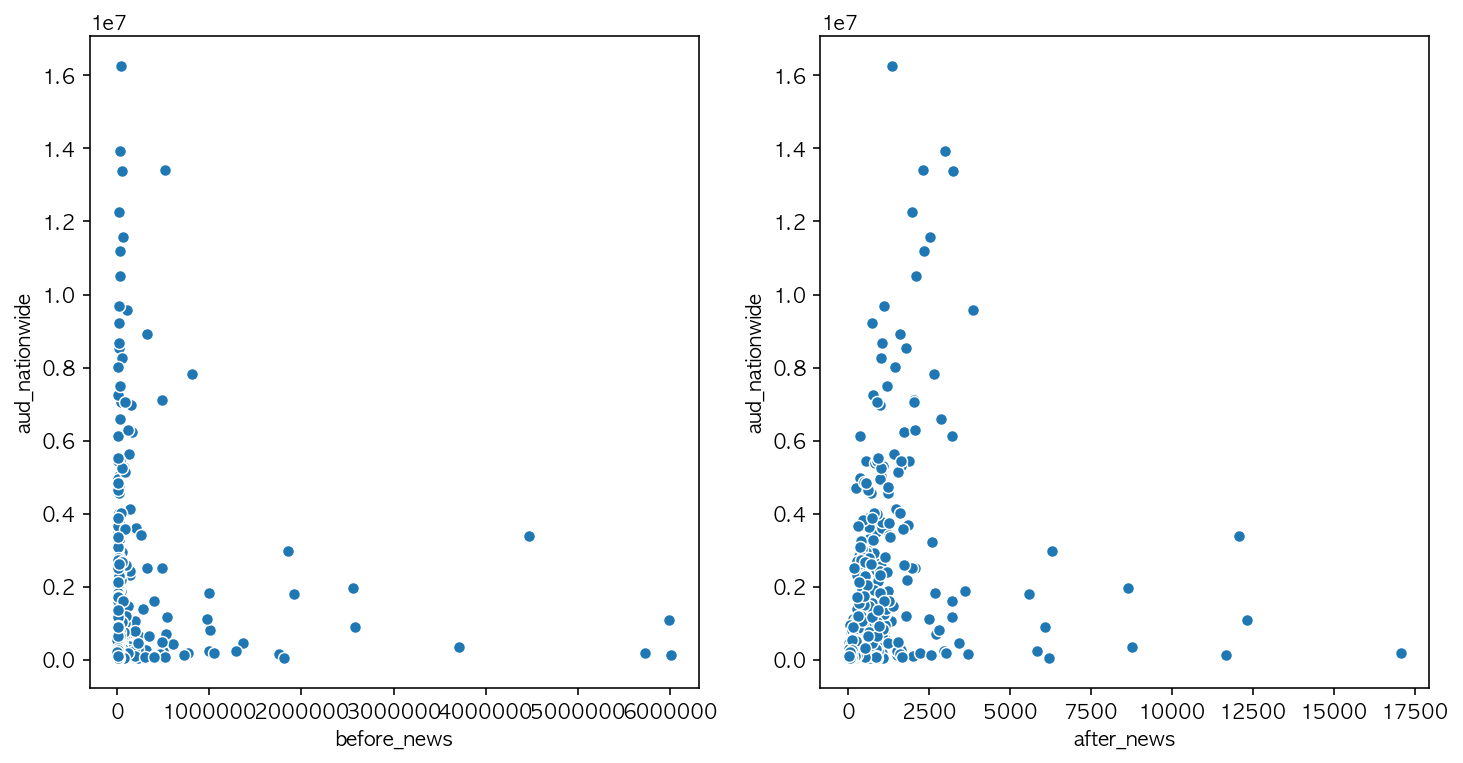

In [158]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x="before_news", y="aud_nationwide", data=df2)
plt.subplot(122)
sns.scatterplot(x="after_news", y="aud_nationwide", data=df2)
plt.show()

In [159]:
df2_1 = df2.copy()

In [160]:
# 로그 취한값에 다시 루트 씌우기

df2_1['log_sqrt_before_news'] = df2_1['before_news'].apply(
    lambda news: np.sqrt(np.log(news)))
df2_1['log_sqrt_after_news'] = df2_1['after_news'].apply(
    lambda news: np.sqrt(np.log(news)))

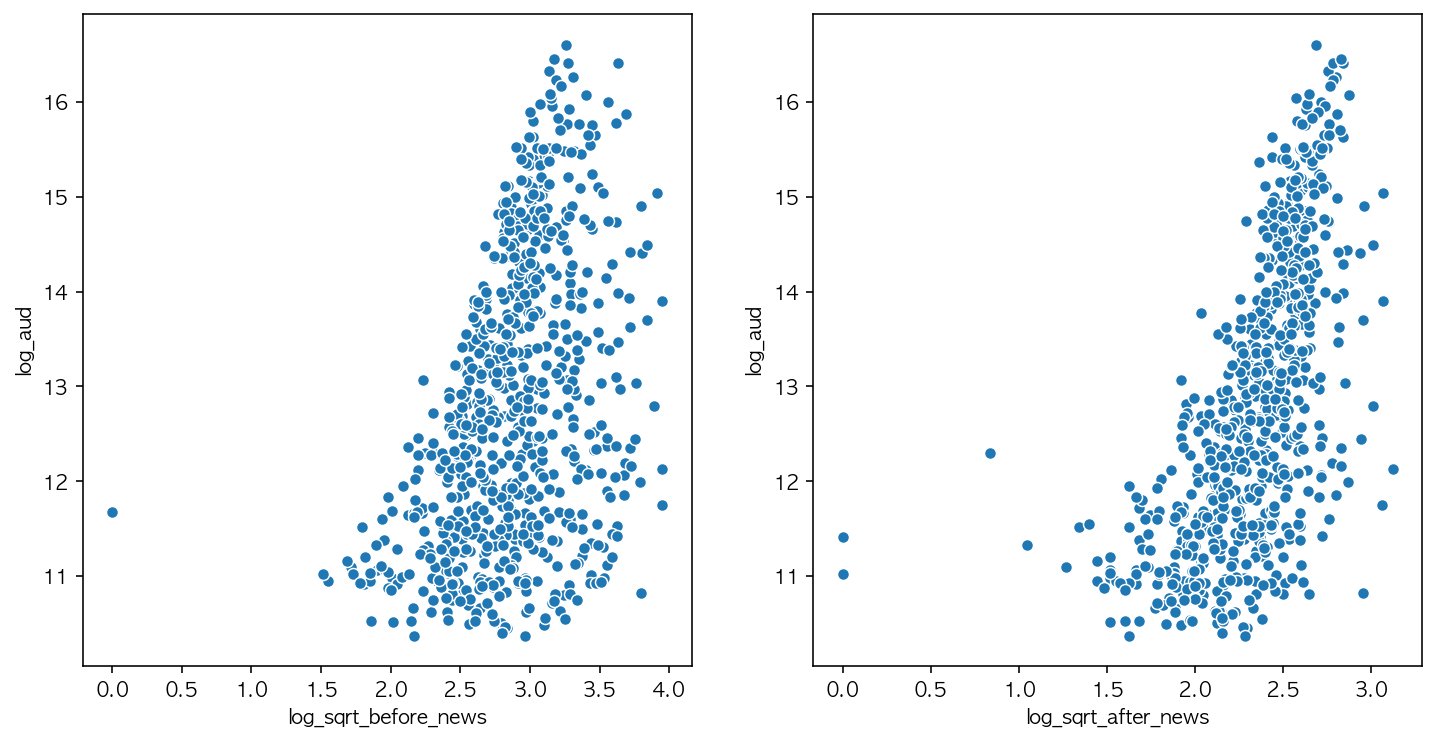

In [161]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.scatterplot(x="log_sqrt_before_news", y="log_aud", data=df2_1)
plt.subplot(122)
sns.scatterplot(x="log_sqrt_after_news", y="log_aud", data=df2_1)
plt.show()

In [162]:
df2['after_news_0to1'] = df2['after_news'].apply(
    lambda num: num if num > 0 else 1.0)

In [163]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences',
                 'director_power', 'actor_power', 'np.sqrt(np.log(before_news))', 'np.sqrt(np.log(after_news_0to1))']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'release_season', 'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model2 = sm.OLS.from_formula("log_aud ~" + "+".join(feature_names), data=df2)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     72.89
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          2.38e-213
Time:                        12:45:12   Log-Likelihood:                -763.97
No. Observations:                 740   AIC:                             1604.
Df Residuals:                     702   BIC:                             1779.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [164]:
X_test['after_news_0to1'] = X_test['after_news'].apply(
    lambda num: num if num > 0 else 1.0)

In [165]:
# kfold 2

from sklearn.model_selection import KFold

kfold_dict['2'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df2)):
    df_train = df2.iloc[idx_train]
    df_test = df2.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                                   'actor_power', 'before_news', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict['2'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
    
kfold_dict_avr.append(sum(kfold_dict['2'])/10)


학습 R2 = 0.79096054, 검증 R2 = 0.80470475
학습 R2 = 0.79455470, 검증 R2 = 0.75902379
학습 R2 = 0.79627357, 검증 R2 = 0.66254370
학습 R2 = 0.79599744, 검증 R2 = 0.76002670
학습 R2 = 0.79518392, 검증 R2 = 0.75911473
학습 R2 = 0.79656699, 검증 R2 = 0.74774122
학습 R2 = 0.79675806, 검증 R2 = 0.73473402
학습 R2 = 0.79661285, 검증 R2 = 0.74848582
학습 R2 = 0.79234050, 검증 R2 = 0.78942271
학습 R2 = 0.79681040, 검증 R2 = 0.74543952


In [166]:
# model2의 테스트 R

pred = result2.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                               'actor_power', 'before_news', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.766161021116791

# model3
- 아웃라이어 3개 제거
- 576 어벤져스: 엔드게임
- 398 캡틴 아메리카: 시빌 워
- 361 어벤져스: 인피니티 워

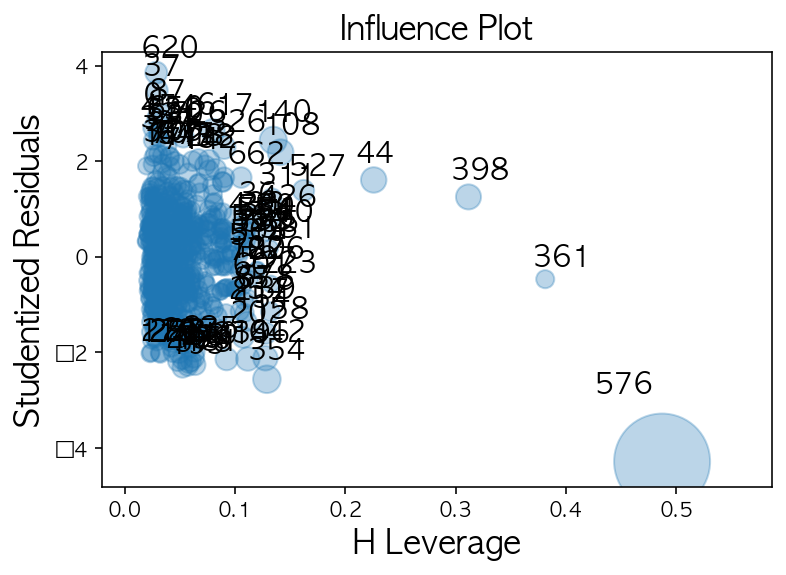

In [167]:
# Cook's distance

sm.graphics.influence_plot(result2, plot_alpha=0.3)
plt.show()

In [168]:
df3 = df2.copy()

In [169]:
df3 = df3.drop(index=[576, 398, 361])

In [170]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences',
                 'director_power', 'actor_power', 'np.sqrt(np.log(before_news))', 'np.sqrt(np.log(after_news_0to1))']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'release_season', 'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model3 = sm.OLS.from_formula("log_aud ~" + "+".join(feature_names), data=df3)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     74.12
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          7.38e-215
Time:                        12:45:24   Log-Likelihood:                -748.24
No. Observations:                 737   AIC:                             1572.
Df Residuals:                     699   BIC:                             1747.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [171]:
# kfold 3

from sklearn.model_selection import KFold

kfold_dict['3'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df3)):
    df_train = df3.iloc[idx_train]
    df_test = df3.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                                   'actor_power', 'before_news', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict['3'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
    
kfold_dict_avr.append(sum(kfold_dict['3'])/10)


학습 R2 = 0.79933897, 검증 R2 = 0.74716355
학습 R2 = 0.80123473, 검증 R2 = 0.72312784
학습 R2 = 0.79609419, 검증 R2 = 0.78505577
학습 R2 = 0.79780854, 검증 R2 = 0.77360499
학습 R2 = 0.80034402, 검증 R2 = 0.75075379
학습 R2 = 0.79836103, 검증 R2 = 0.76381822
학습 R2 = 0.79696689, 검증 R2 = 0.76380003
학습 R2 = 0.79874544, 검증 R2 = 0.74363119
학습 R2 = 0.79266267, 검증 R2 = 0.81363123
학습 R2 = 0.80106878, 검증 R2 = 0.75090421


In [172]:
# model3의 테스트 R

pred = result3.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                               'actor_power', 'before_news', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7739654530371688

# model4
- running_times 처리
    - running_times * rating_audiences

In [173]:
df4 = df3.copy()

In [174]:
# # 장르별 러닝타임과 rating_audiences

# plt.figure(figsize=(10, 4))
# plt.title("장르별 러닝타임과 rating_audiences")
# plt.scatter(df4[df4["genre"] == "범죄"]["running_times"],
#             df4[df4["genre"] == "범죄"]["rating_audiences"])

# plt.show()

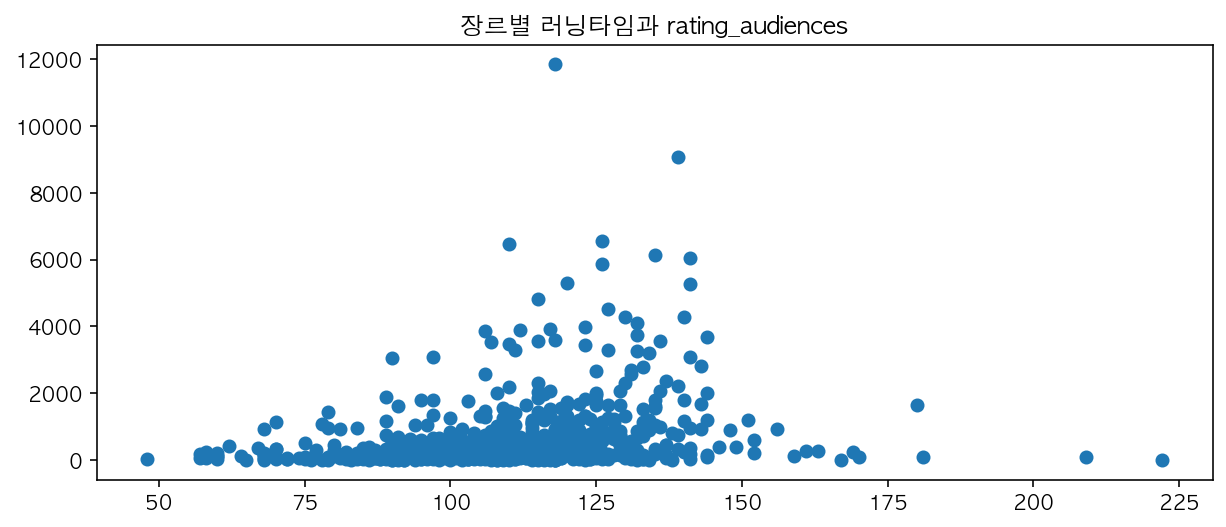

In [175]:
# 러닝타임과 rating_audiences

plt.figure(figsize=(10, 4))
plt.title("장르별 러닝타임과 rating_audiences")
plt.scatter(df4["running_times"],
            df4["rating_audiences"])

plt.show()

In [176]:
# 16개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times*rating_audiences', 'rating_audiences',
                 'director_power', 'actor_power', 'np.sqrt(np.log(before_news))', 'np.sqrt(np.log(after_news_0to1))']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'release_season', 'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model4 = sm.OLS.from_formula("log_aud ~" + "+".join(feature_names), data=df4)
result4 = model4.fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     77.97
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          6.05e-221
Time:                        12:45:35   Log-Likelihood:                -733.27
No. Observations:                 737   AIC:                             1543.
Df Residuals:                     699   BIC:                             1717.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [177]:
# kfold 4

from sklearn.model_selection import KFold

kfold_dict['4'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df4)):
    df_train = df4.iloc[idx_train]
    df_test = df4.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                                   'actor_power', 'before_news', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict['4'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
    
kfold_dict_avr.append(sum(kfold_dict['4'])/10)


학습 R2 = 0.80751765, 검증 R2 = 0.75538730
학습 R2 = 0.80840252, 검증 R2 = 0.74377570
학습 R2 = 0.80585289, 검증 R2 = 0.77808247
학습 R2 = 0.80573261, 검증 R2 = 0.78314544
학습 R2 = 0.80764826, 검증 R2 = 0.76604381
학습 R2 = 0.80481755, 검증 R2 = 0.79088956
학습 R2 = 0.80740249, 검증 R2 = 0.72770151
학습 R2 = 0.80597887, 검증 R2 = 0.76367135
학습 R2 = 0.80128613, 검증 R2 = 0.81996699
학습 R2 = 0.80913438, 검증 R2 = 0.75833659


In [178]:
# model4의 테스트 R

pred = result4.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                               'actor_power', 'before_news', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7957602180083694

# model5
- 뉴스기사 처리 : before_news와 after_news를 하나로 묶기
    - `np.sqrt(np.log(before_news))*np.log(after_news_0to1)`

In [179]:
df5 = df4.copy()

In [180]:
# 'np.sqrt(np.log(before_news))', 'np.sqrt(np.log(after_news_0to1))'

In [181]:
# 15개의 컬럼 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times*rating_audiences', 'rating_audiences',
                 'director_power', 'actor_power', 'np.sqrt(np.log(before_news))*np.log(after_news_0to1)']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'release_season', 'nation', 'genre', 'rate', 'C(sequel)', 'C(original)']
model5 = sm.OLS.from_formula("log_aud ~" + "+".join(feature_names), data=df5)
result5 = model5.fit()
print(result5.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     80.82
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          9.44e-223
Time:                        12:45:59   Log-Likelihood:                -731.19
No. Observations:                 737   AIC:                             1536.
Df Residuals:                     700   BIC:                             1707.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [182]:
# kfold 5

from sklearn.model_selection import KFold

kfold_dict['5'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df5)):
    df_train = df5.iloc[idx_train]
    df_test = df5.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                                   'actor_power', 'before_news', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict['5'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
    
kfold_dict_avr.append(sum(kfold_dict['5'])/10)


학습 R2 = 0.80871656, 검증 R2 = 0.75615421
학습 R2 = 0.80988915, 검증 R2 = 0.74079827
학습 R2 = 0.80715583, 검증 R2 = 0.77794298
학습 R2 = 0.80747386, 검증 R2 = 0.77822997
학습 R2 = 0.80786909, 검증 R2 = 0.77635914
학습 R2 = 0.80571820, 검증 R2 = 0.79449002
학습 R2 = 0.80849025, 검증 R2 = 0.73100792
학습 R2 = 0.80561645, 검증 R2 = 0.79213873
학습 R2 = 0.80249721, 검증 R2 = 0.82097436
학습 R2 = 0.81030083, 검증 R2 = 0.75951412


In [183]:
# model5의 테스트 R

pred = result5.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                               'actor_power', 'before_news', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7970691404424421

# model6
- 장르 처리

In [101]:
df6 = df5.copy()

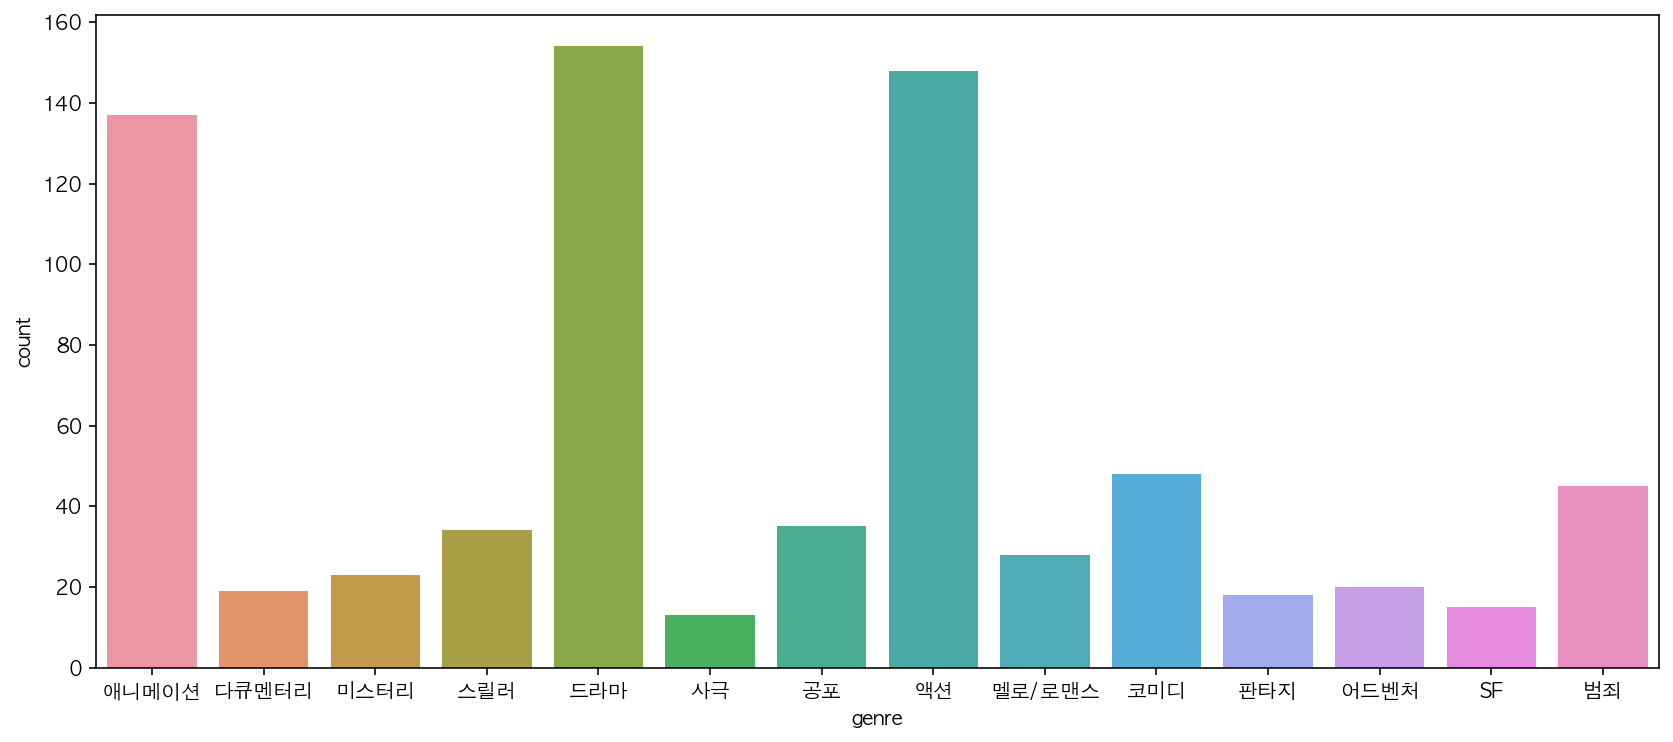

In [195]:
# 장르별 영화갯수

plt.figure(figsize=(14, 6))
sns.countplot(df6['genre']);

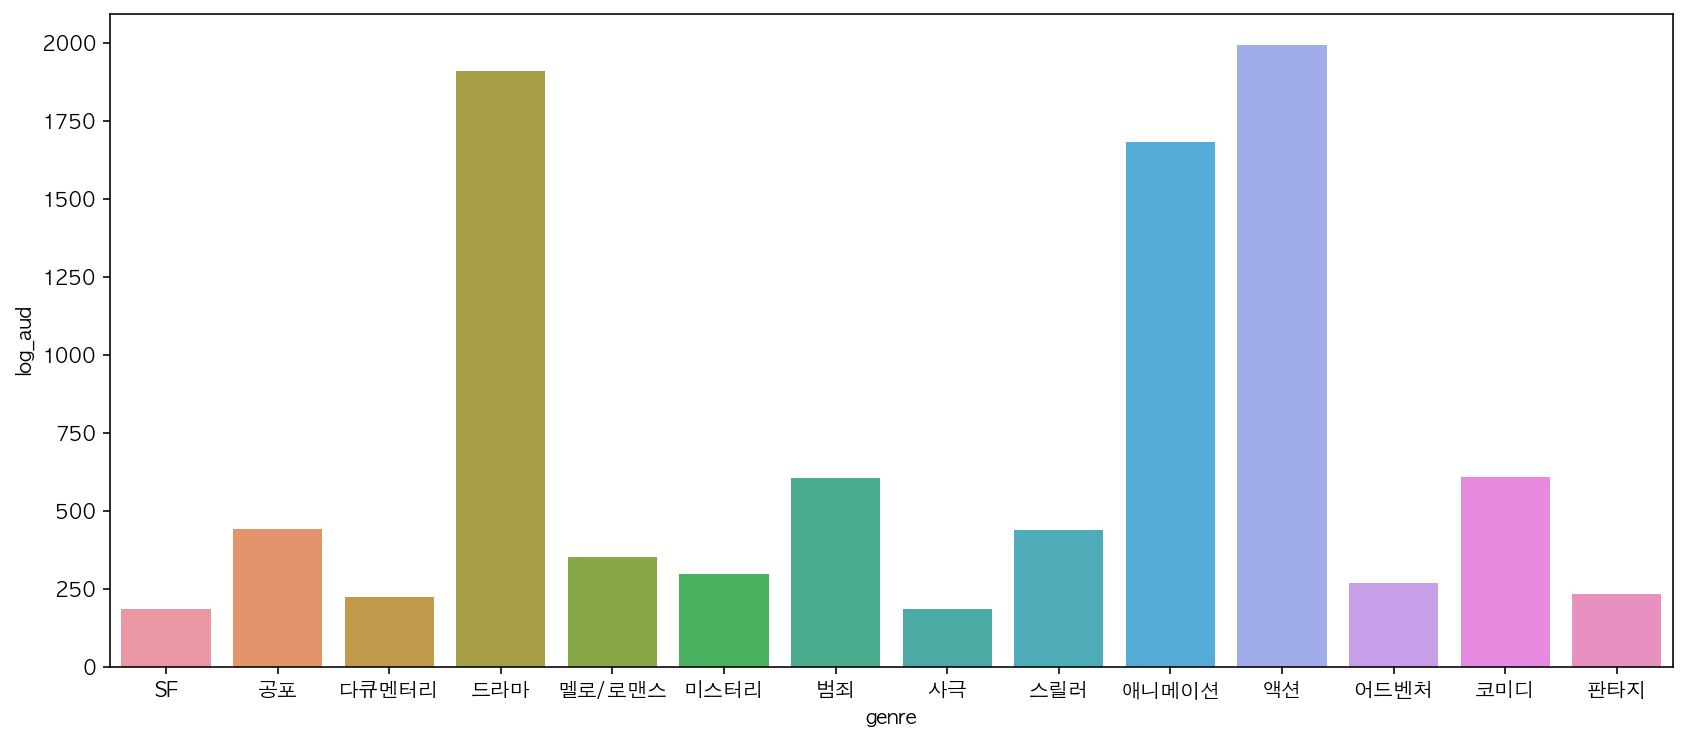

In [248]:
# 장르별 관객수

plt.figure(figsize=(14, 6))
sns.barplot(x='genre', y='log_aud', data=genre_df);

In [249]:
# 드라마, 애니메이션, 액션, 공포, 범죄, 스릴러, 코미디
# 기타

In [311]:
def genre_func(genre):
    if genre in ['드라마', '애니메이션', '액션', '공포', '범죄', '스릴러', '코미디']:
        return 'A'
    else:
        return 'B'

In [312]:
def genre_ani_func(genre):
    if genre == '애니메이션':
        return 1
    else: 
        return 0

In [313]:
df6['genre_cat'] = df6['genre'].apply(genre_func)

In [314]:
df6['genre_ani_cat'] = df6['genre'].apply(genre_ani_func)

In [315]:
# genre_df

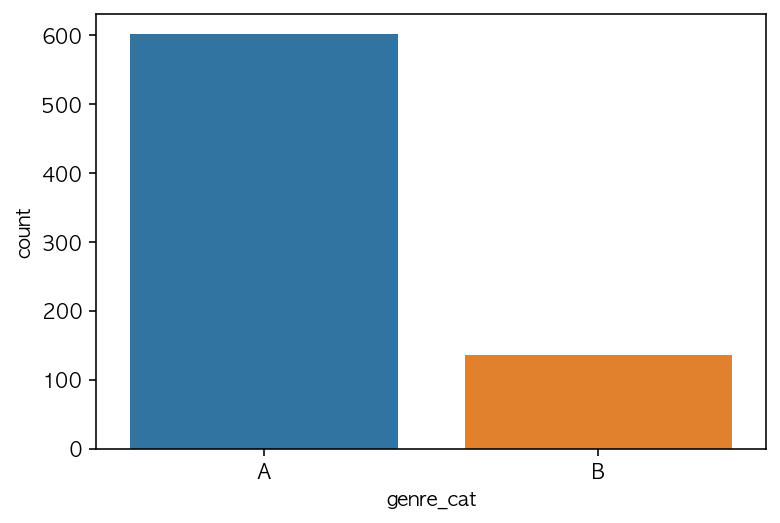

In [316]:
# 주요 장르 & 기타

sns.countplot(df6['genre_cat']);

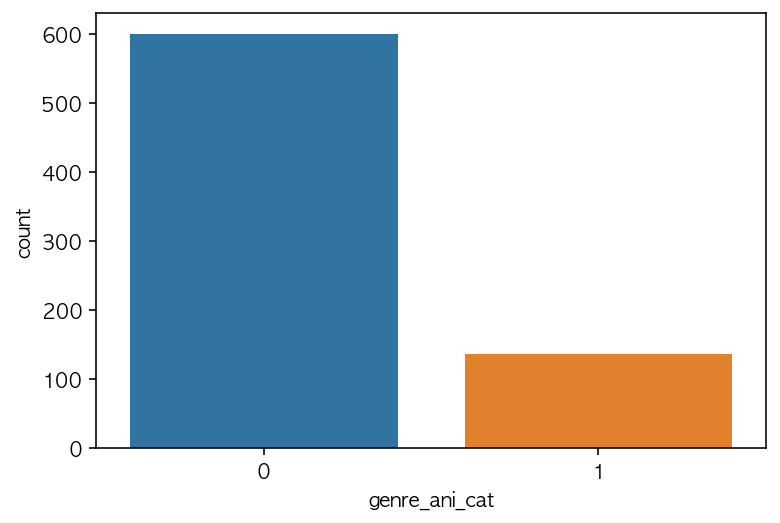

In [317]:
# 애니메이션 & 기타

sns.countplot(df6['genre_ani_cat']);

In [336]:
# 15개의 컬럼 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times*rating_audiences', 'rating_audiences',
                 'director_power', 'actor_power', 'np.sqrt(np.log(before_news))*np.log(after_news_0to1)']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'release_season', 'nation', 'genre_ani_cat', 'rate', 'C(sequel)', 'C(original)']
model6 = sm.OLS.from_formula("log_aud ~" + "+".join(feature_names), data=df6)
result6 = model6.fit()
print(result6.summary())

                            OLS Regression Results                            
Dep. Variable:                log_aud   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     118.5
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          7.20e-230
Time:                        16:23:25   Log-Likelihood:                -743.04
No. Observations:                 737   AIC:                             1536.
Df Residuals:                     712   BIC:                             1651.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [337]:
# kfold 6

from sklearn.model_selection import KFold

kfold_dict['6'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df6)):
    df_train = df6.iloc[idx_train]
    df_test = df6.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                                   'actor_power', 'before_news', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre_ani_cat', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict['6'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
    
kfold_dict_avr.append(sum(kfold_dict['6'])/10)


학습 R2 = 0.80209186, 검증 R2 = 0.75737482
학습 R2 = 0.80311698, 검증 R2 = 0.74358032
학습 R2 = 0.79881555, 검증 R2 = 0.79453903
학습 R2 = 0.80221789, 검증 R2 = 0.76899739
학습 R2 = 0.80143712, 검증 R2 = 0.77134933
학습 R2 = 0.79945308, 검증 R2 = 0.78899368
학습 R2 = 0.80161812, 검증 R2 = 0.73482739
학습 R2 = 0.79857540, 검증 R2 = 0.79394278
학습 R2 = 0.79580328, 검증 R2 = 0.82215319
학습 R2 = 0.80368506, 검증 R2 = 0.75781673


In [333]:
X_test['genre_cat'] = X_test['genre'].apply(genre_func)
X_test['genre_ani_cat'] = X_test['genre'].apply(genre_ani_func)

In [338]:
# model6의 테스트 R

pred = result6.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                               'actor_power', 'before_news', 'after_news_0to1', 'dist_cat', 'release_season', 'nation', 'genre_ani_cat', 'rate', 'sequel', 'original']])
rss = ((y_test['log_aud'] - pred) ** 2).sum()
tss = ((y_test['log_aud'] - y_test['log_aud'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared

0.7994462386978678

In [322]:
kfold_dict_avr

[0.7425876422947767,
 0.7425876422947767,
 0.7511236938422174,
 0.7615490811807625,
 0.7687000719742375,
 0.7727609717034971,
 0.7733574661112462,
 0.77320054979144,
 0.7733574661112462,
 0.77320054979144,
 0.7733574661112462,
 0.7744655950123511,
 0.7756151206384642,
 0.7733574661112462,
 0.7733238536499256]

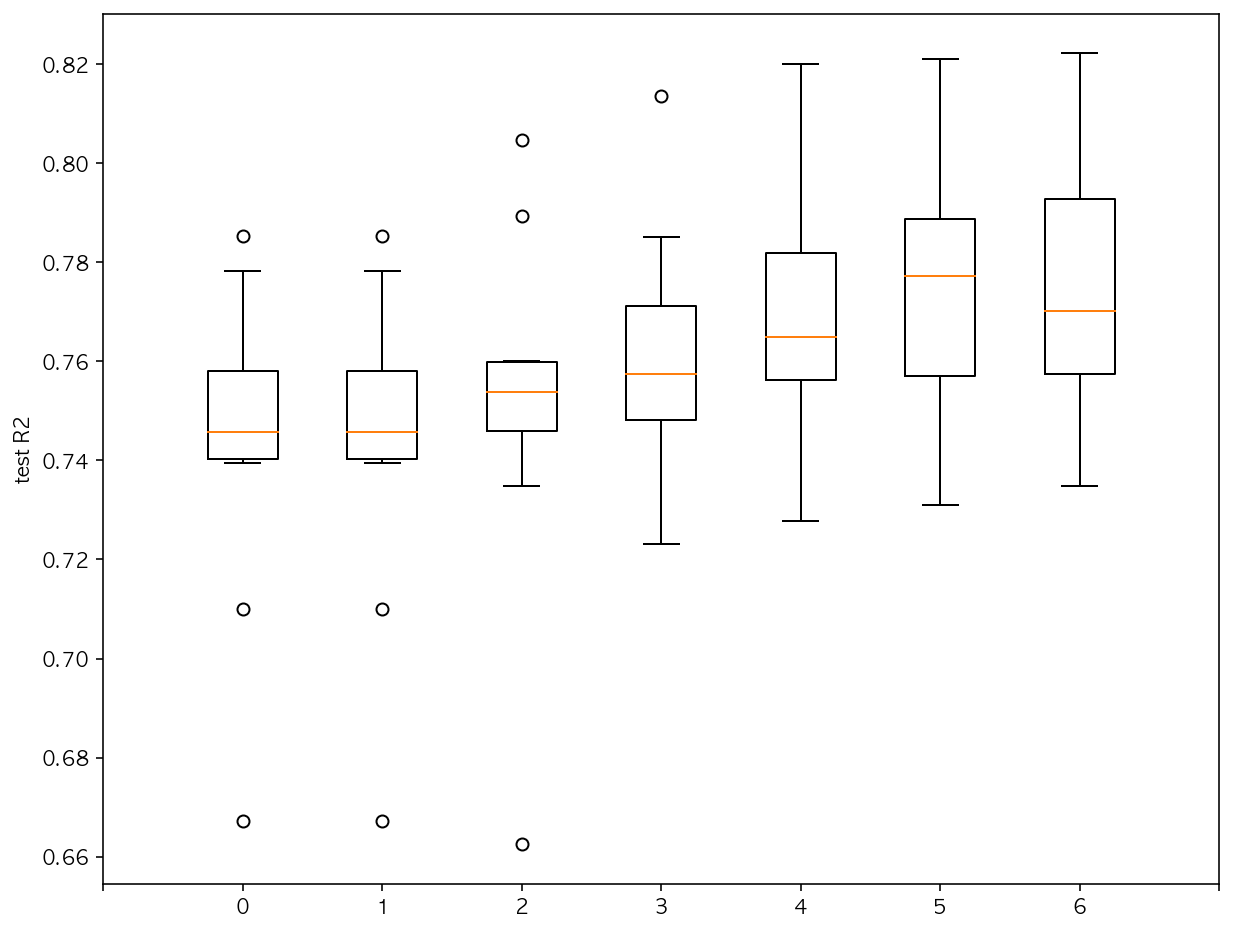

In [340]:
for i in range(0, len(kfold_dict)):
    kfold_df[str(i)] = kfold_dict[str(i)]

plt.figure(figsize=(10, 8))
plt.boxplot((kfold_df['0'], kfold_df['1'],
             kfold_df['2'], kfold_df['3'], kfold_df['4'], kfold_df['5'], kfold_df['6']))
plt.ylabel("test R2")
plt.xticks(np.arange(9), ('', '0', '1', '2', '3', '4', '5', '6'))

plt.show()